In [133]:
import ee
import wxee
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy 
import xarray as xr

from codepropre import grid

In [134]:
# initialize ee API library
ee.Initialize()
# initialize the wxee
wxee.Initialize()
"""The function now works, and allows the user to get the necessary meteo data, i.e. pressure and 10m-wind components around a (lat, long) point.
A plotting function has been implemented via a boolean argument to allow visual representations."""

lat, long = -25.6, 28.67

SATS = ["ERA5", "GEOS", "GFS"]
SATELLITES = {}
SATELLITES["ERA5"]  = ['ECMWF/ERA5_LAND/HOURLY', 11132, "surface_pressure", "u_component_of_wind_10m", "v_component_of_wind_10m"] 
#name, pixel_resolution, pressure, east wind component, north wind component
SATELLITES["GEOS"] = ['NASA/GEOS-CF/v1/rpl/tavg1hr', 27750, "PS", "U10M", "V10M"]
SATELLITES["GFS"] =["NOAA/GFS0P25", 27830, None, "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground"]

In [135]:
square = 250 #size of the square that will be studied in kilometers
Rterre = 6378

def selection_carre(lat, lon):
    
    lat_max = min(lat + (square * 180 / (Rterre * np.pi)), 90)
    lat_min = max(lat - (square * 180 / (Rterre * np.pi)), -90)

    lat_rad = lat * np.pi / 180
    lon_delta = square * 180 / (Rterre * np.pi * np.cos(lat_rad))
    lon_max = (lon + lon_delta + 180) % 360 - 180
    lon_min = (lon - lon_delta + 180) % 360 - 180

    return lon_min, lon_max, lat_min, lat_max

In [136]:
def get_meteo_geos(lat : float, long : float, sat_grid, date="2023-06-27", time=16, plot=False):

    hour = time
    ext = selection_carre(lat, long)
    rectangle = [[ext[0],ext[2]],
            [ext[1],ext[2]],
            [ext[1],ext[3]],
            [ext[0],ext[3]],
            [ext[0],ext[2]]]

    #TEST WITH GEOS

    name = 'NASA/GEOS-CF/v1/rpl/tavg1hr'
    resolution = 27750
    ind_pressure = 'PS'
    ind_u, ind_v = 'U10M', 'V10M'

    ee_rect = ee.Geometry.Polygon(rectangle, None, False)
    datenext="2023-06-28"
    ee_date1 = ee.Date(date)
    ee_date2 = ee.Date(datenext)

    collection_filtered_sorted = (ee.ImageCollection(name)
                            .filterBounds(ee_rect)
                            .filterDate(ee_date1, ee_date2)
                            .select([ind_pressure, ind_u, ind_v])).sort('system:time_start')

    ds = collection_filtered_sorted.wx.to_xarray(region=ee_rect, scale=resolution, crs='EPSG:4326', # crs = 4326 is lat,lon projection
                        masked=True, nodata=-999999)
    
    ds_time = ds.isel(time=hour)
    data = ds_time[[ind_pressure, ind_u, ind_v]]


    if plot:

            fig, axes = plt.subplots(
                1, 3,
                figsize=(15, 5),
                subplot_kw={'projection': ccrs.PlateCarree()}
            )

            # Set the super title (move down `top` to make space)
            fig.suptitle(f"GEOS - Time: {date}T{time}h", fontsize=16)
            fig.subplots_adjust(top=0.85)  # Leave space for suptitle

            # Titles and data indices for the subplots
            titles = ["Pressure (Pa)", "Eastward wind (m/s)", "Northward wind (m/s)"]
            data_indices = [ind_pressure, ind_u, ind_v]

            # Plot each subplot
            for ax, title, idx in zip(axes, titles, data_indices):
                ax.set_title(title, fontsize=12, pad=15)
                data[idx].plot(
                    x='x',
                    y='y',
                    antialiased=True,
                    transform=ccrs.PlateCarree(),
                    ax=ax,
                    add_colorbar=True,
                    add_labels=False
                )

            plt.tight_layout(w_pad=2)
            plt.show()

    return data
"""
        # Titles and data indices for the subplots
        titles = ["Pressure (Pa)", "Eastward wind (m/s)", "Northward wind (m/s)"]
        data_indices = [ind_pressure, ind_u, ind_v]

        # Plot each subplot
        for ax, title, idx in zip(axes, titles, data_indices):
            ax.set_title(title, fontsize=12, pad=15)
            data[idx].plot(
                x='x',
                y='y',
                antialiased=True,
                transform=ccrs.PlateCarree(),
                ax=ax,
                add_colorbar=True,
                add_labels=False
            )

        plt.tight_layout(w_pad=2)
        plt.show()

    

    return data

data = get_meteo_geos(-25.6, 28.67, grid, plot=True)
print(data)

"""

'\n        # Titles and data indices for the subplots\n        titles = ["Pressure (Pa)", "Eastward wind (m/s)", "Northward wind (m/s)"]\n        data_indices = [ind_pressure, ind_u, ind_v]\n\n        # Plot each subplot\n        for ax, title, idx in zip(axes, titles, data_indices):\n            ax.set_title(title, fontsize=12, pad=15)\n            data[idx].plot(\n                x=\'x\',\n                y=\'y\',\n                antialiased=True,\n                transform=ccrs.PlateCarree(),\n                ax=ax,\n                add_colorbar=True,\n                add_labels=False\n            )\n\n        plt.tight_layout(w_pad=2)\n        plt.show()\n\n    \n\n    return data\n\ndata = get_meteo_geos(-25.6, 28.67, grid, plot=True)\nprint(data)\n\n'

Requesting data:   0%|          | 0/24 [00:00<?, ?it/s]

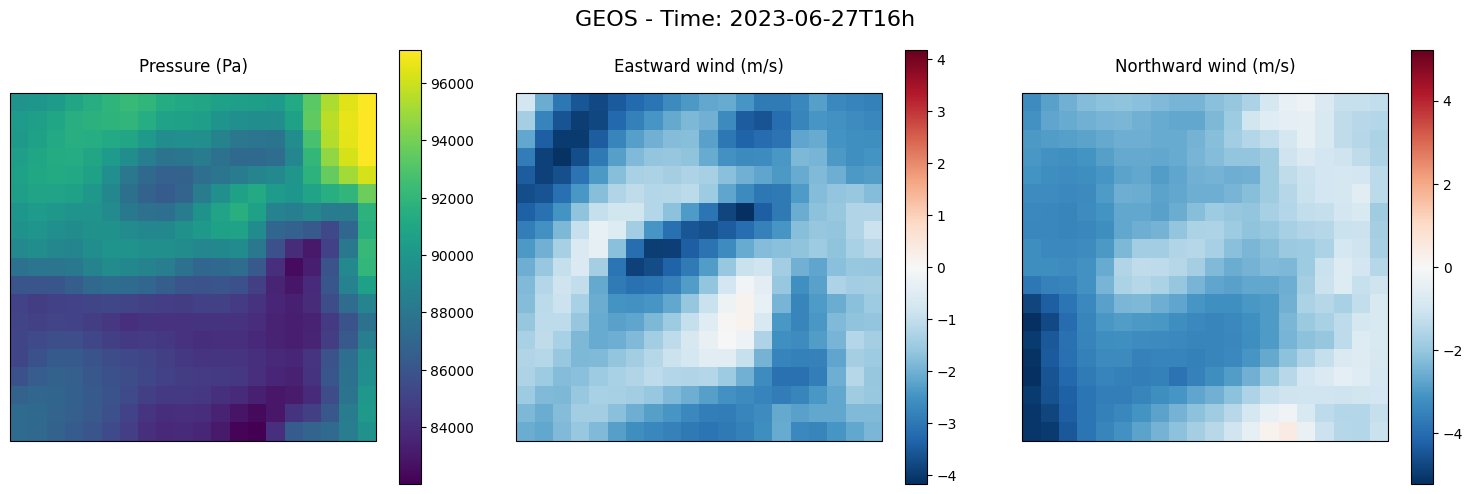

In [137]:
data = get_meteo_geos(-25.6, 28.67, grid, plot=True)

In [ ]:
newdata = data.interp(
    x=np.sort(grid["longitude"].values.flatten()),
    y=np.sort(grid["latitude"].values.flatten()),
    method="linear"
)


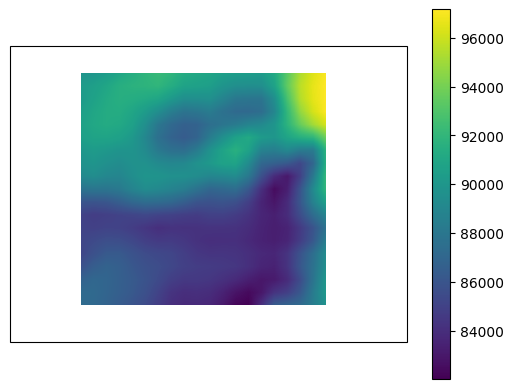

In [171]:
ax = plt.axes(projection=ccrs.PlateCarree())
newdata.PS.plot(
    x='x',
    y='y',
    antialiased=True,
    transform=ccrs.PlateCarree(),
    ax=ax,
    add_colorbar=True,
    add_labels=False
)


In [140]:
grid

<xarray.Dataset> Size: 173kB
Dimensions:                              (time: 1, scanline: 102,
                                          ground_pixel: 42, corner: 4,
                                          layer: 12, level: 13)
Coordinates:
  * scanline                             (scanline) float64 816B 973.0 ... 1....
  * ground_pixel                         (ground_pixel) float64 336B 164.0 .....
  * time                                 (time) datetime64[ns] 8B 2023-07-13
  * corner                               (corner) float64 32B 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 96B 0.0 1.0 ... 11.0
  * level                                (level) float64 104B 0.0 1.0 ... 12.0
    latitude                             (time, scanline, ground_pixel) float32 17kB ...
    longitude                            (time, scanline, ground_pixel) float32 17kB ...
Data variables:
    delta_time                           (time, scanline, ground_pixel) datetime64[ns] 34kB ...
    time_utc                             (time, scanline, ground_pixel) object 34kB ...
    qa_value                             (time, scanline, ground_pixel) float32 17kB ...
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 17kB ...
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 17kB ...
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 17kB ...

In [101]:
newdata

<xarray.Dataset> Size: 440MB
Dimensions:      (y: 4284, x: 4284)
Coordinates:
    time         datetime64[ns] 8B 2023-06-27T16:00:00
    spatial_ref  int64 8B 0
  * x            (x) float32 17kB 24.94 24.95 24.97 24.98 ... 32.55 32.57 32.59
  * y            (y) float32 17kB -28.5 -28.49 -28.47 ... -22.85 -22.83 -22.8
Data variables:
    PS           (y, x) float64 147MB nan nan nan nan nan ... nan nan nan nan
    U10M         (y, x) float64 147MB nan nan nan nan nan ... nan nan nan nan
    V10M         (y, x) float64 147MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              -999999.0
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:

"""def pressure(lat, lon):
    print(lat.shape, lon.shape)
    out = newdata.sel(x=lon, y=lat).PS
    print(out.shape)
    return out

# Apply function and put in new 'surface_pressure' variable
grid['surface_pressure'] = xr.apply_ufunc(
    pressure,
    grid.latitude,
    grid.longitude)
"""
grid["surface_pressure"] = xr.zeros_like(grid.methane_mixing_ratio_bias_corrected)

for pixel in grid.ground_pixel.values:
    for line in grid.scanline.values:
        
        latitude = grid.sel(ground_pixel=pixel, scanline=line).latitude.data[0]
        longitude = grid.sel(ground_pixel=pixel, scanline=line).longitude.data[0]


        grid.sel(ground_pixel=pixel, scanline=line)["surface_pressure"] = newdata.sel(x=longitude, y=latitude).PS.data


MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'surface_pressure'}

In [146]:
np.unique(grid.surface_pressure.values)

array([0.], dtype=float32)

In [75]:
def tracer_methane(donnees=newdata):

    lon_min, lon_max, lat_min, lat_max = selection_carre(lat, long)
    img_extent = (lon_min, lon_max, lat_min, lat_max)

    fig = plt.figure(figsize = (7, 7))
    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent(img_extent, crs = ccrs.PlateCarree())
    ax.coastlines('10m', linewidth=1.5, color='black')
   
    donnees.PS.plot(x='x',
                           y='y',
                           antialiased=True,
                           cmap='viridis',
                           transform=ccrs.PlateCarree()
                           )
   
    plt.show()

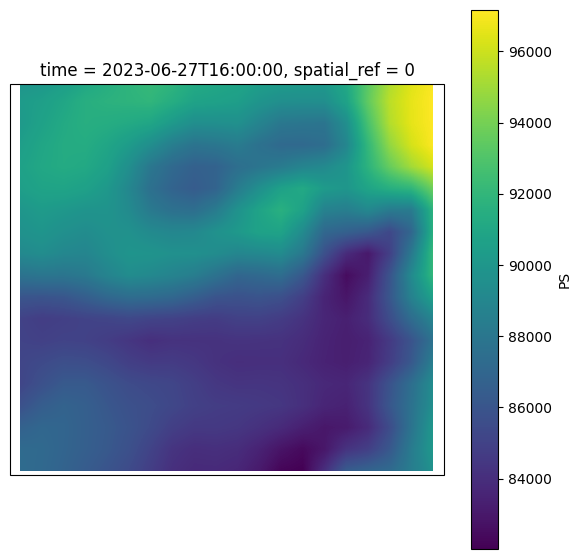

In [172]:
tracer_methane()